In [ ]:
from tests.fixture_testing.json_corpus import JsonCorpus
from tests.fixture_testing.fixture_test import FixtureTest
from adapters.testing.in_memory_storage import InMemoryStorage
from models import Topic, NegativeRules, TopicPolicy
from observer import Observer
from tests.fixture_testing.fixture_fetch import FixtureFetch
from tests.fixture_testing.fixture_search import FixtureSearch
from adapters.testing.in_memory_storage import InMemoryStorage
from models import Topic, NegativeRules, TopicPolicy
from adapters.testing.in_memory_storage import InMemoryStorage
from adapters.testing.search.toy_query_planner import ToyQueryPlanner
from adapters.testing.toy_embed import ToyEmbed
from adapters.testing.filtering.pass_filter import PassFilter
from adapters.testing.filtering.seen_deduper import SeenDeduper
from adapters.testing.filtering.simple_ranker import SimpleRanker
from adapters.testing.kmeans2_clusterer import KMeans2Clusterer
from adapters.testing.simple_namer import SimpleNamer
from core_services.topic_updater import TopicUpdater
from core_services.cluster_smoother import ClusterSmoother
from core_services.emergence_detector import EmergenceDetector
from core_services.cluster_matcher import ClusterMatcher
from core_services.orchestrator import Orchestrator
from observer import Observer
import uuid


# --- Fixture corpus & fetcher
corpus = JsonCorpus("tests/fixture_testing/corpus/test1")


# --- Storage + initial topic
storage = InMemoryStorage()
topic = Topic(
    id=str(uuid.uuid4()),
    name="New ML Models",
    seeds=["llm", "transformer", "benchmark"],
    negative=NegativeRules(),
    policy=TopicPolicy(
        m_min=3,                 # Number of docs (mass) in a cluster for promotion
        tau_cohesion=0.5,        # high cohesion -> docs are similar to each other
        tau_separation=0.80,     # lower the number, closer the cluster can be to parent before promotion
        persistence_min=2,       # Number of times a cluster must meet all thresholds before being promoted
        ema_alpha_topic=0.10,
        ema_beta_cluster=0.40,
    ),
)
storage.save_topic(topic)

# --- Fixture corpus & fetcher
fetch = FixtureFetch(corpus)
search = FixtureSearch(corpus)

matcher = ClusterMatcher()

# --- Wire orchestrator with fixture adapters
orchestrator = Orchestrator(
    planner=ToyQueryPlanner(),
    searcher=search,  # <- fixture search
    fetcher=fetch,                                   # <- fixture fetch
    embedder=ToyEmbed(dim=32),
    storage=storage,
    ranker=SimpleRanker(),
    filtr=PassFilter(),
    deduper=SeenDeduper(),           # within-tick dedup handled below (pre-Doc)
    clusterer=KMeans2Clusterer(),
    smoother=ClusterSmoother(beta=topic.policy.ema_beta_cluster),
    updater=TopicUpdater(recency_lambda=0.00),
    emergence=EmergenceDetector(),
    namer=SimpleNamer(),
    matcher=matcher,
    window_days=30,
    K_queries=6,
    K_keep=20,
)

observer = Observer(storage)

fixture_test = FixtureTest(
    corpus, 
    observer, 
    orchestrator, 
    topic, 
    10)

fixture_test.test()

print(observer.observations)

19:35:27 orchestrator DEBUG: Starting tick for topic 981e01c9-fad0-412d-a342-26e4416126aa
19:35:27 orchestrator DEBUG: Planned 3 queries: ['llm', 'transformer', 'benchmark']
19:35:27 orchestrator DEBUG: Filtered: 18 → Unique: 6 → Top-K: 6
19:35:27 core_services.cluster_matcher DEBUG: Matching or creating cluster state for topic 981e01c9-fad0-412d-a342-26e4416126aa with snapshot C0 Tau match: 0.4
19:35:27 core_services.cluster_matcher DEBUG: Best sim for topic 981e01c9-fad0-412d-a342-26e4416126aa with snapshot C0: -1.0
19:35:27 core_services.cluster_matcher DEBUG: No adequate cluster state match found for topic 981e01c9-fad0-412d-a342-26e4416126aa with snapshot C0, creating new state: cand_afd386d1
19:35:27 core_services.cluster_matcher DEBUG: Matching or creating cluster state for topic 981e01c9-fad0-412d-a342-26e4416126aa with snapshot C1 Tau match: 0.4
19:35:27 core_services.cluster_matcher DEBUG: Best sim for topic 981e01c9-fad0-412d-a342-26e4416126aa with snapshot C1: 0.06790591825

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import List, Dict, Any

def plot_topic_ema_over_time(observations: List[Any], topic_id: str = None):
    """
    Plot topic EMA values over time to see when new topics are created.
    
    Args:
        observations: List of Observation objects from the observer
        topic_id: Specific topic to plot (if None, plots all topics)
    """
    # Extract data
    data = []
    for obs in observations:
        if topic_id is None or obs.topic.topic_id == topic_id:
            # Calculate topic EMA (centroid_long if available, otherwise centroid_short_ema)
            topic_ema = obs.topic.centroid_long if obs.topic.centroid_long is not None else obs.topic.centroid_short_ema
            
            if topic_ema is not None:
                # Use the magnitude of the EMA vector as a single value
                ema_magnitude = np.linalg.norm(topic_ema)
                data.append({
                    'tick': obs.tick,
                    'topic_id': obs.topic.topic_id,
                    'seeds': obs.topic.seeds,
                    'ema_magnitude': ema_magnitude,
                    'weight_sum': obs.topic.weight_sum,
                    'num_clusters': len(obs.topic.clusters)
                })
    
    if not data:
        print("No data found for the specified topic(s)")
        return
    
    df = pd.DataFrame(data)
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot 1: Topic EMA magnitude over time
    for topic in df['topic_id'].unique():
        topic_data = df[df['topic_id'] == topic]
        seeds = topic_data['seeds'].iloc[0]
        seeds_label = ', '.join(seeds[:3])  # Show first 3 seeds
        if len(seeds) > 3:
            seeds_label += '...'
        ax1.plot(topic_data['tick'], topic_data['ema_magnitude'], 
                marker='o', label=f'[{seeds_label}]', linewidth=2)
    
    ax1.set_xlabel('Tick')
    ax1.set_ylabel('Topic EMA Magnitude')
    ax1.set_title('Topic EMA Magnitude Over Time')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Weight sum over time (shows topic activity)
    for topic in df['topic_id'].unique():
        topic_data = df[df['topic_id'] == topic]
        seeds = topic_data['seeds'].iloc[0]
        seeds_label = ', '.join(seeds[:3])  # Show first 3 seeds
        if len(seeds) > 3:
            seeds_label += '...'
        ax2.plot(topic_data['tick'], topic_data['weight_sum'], 
                marker='s', label=f'[{seeds_label}]', linewidth=2)
    
    ax2.set_xlabel('Tick')
    ax2.set_ylabel('Weight Sum')
    ax2.set_title('Topic Weight Sum Over Time')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== Topic Summary ===")
    for topic in df['topic_id'].unique():
        topic_data = df[df['topic_id'] == topic]
        seeds = topic_data['seeds'].iloc[0]
        seeds_str = ', '.join(seeds)
        print(f"Topic [{seeds_str}]:")
        print(f"  - First appearance: tick {topic_data['tick'].min()}")
        print(f"  - Last appearance: tick {topic_data['tick'].max()}")
        print(f"  - Max EMA magnitude: {topic_data['ema_magnitude'].max():.3f}")
        print(f"  - Max weight sum: {topic_data['weight_sum'].max():.3f}")
        print(f"  - Max clusters: {topic_data['num_clusters'].max()}")
        print()

def plot_topic_creation_timeline(observations: List[Any]):
    """
    Create a timeline showing when topics first appear.
    """
    topic_first_seen = {}
    
    for obs in observations:
        topic_id = obs.topic.topic_id
        if topic_id not in topic_first_seen:
            topic_first_seen[topic_id] = obs.tick
    
    # Sort topics by first appearance
    sorted_topics = sorted(topic_first_seen.items(), key=lambda x: x[1])
    
    # Create timeline plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    y_pos = 0
    for topic_id, first_tick in sorted_topics:
        ax.scatter(first_tick, y_pos, s=100, alpha=0.7, label=f'Topic {topic_id}')
        ax.text(first_tick + 0.1, y_pos, f'Topic {topic_id}', va='center')
        y_pos += 1
    
    ax.set_xlabel('Tick')
    ax.set_ylabel('Topic')
    ax.set_title('Topic Creation Timeline')
    ax.set_yticks(range(len(sorted_topics)))
    ax.set_yticklabels([f'Topic {",".join(topic.seeds)}' for tid, topic in sorted_topics])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("=== Topic Creation Timeline ===")
    for topic_id, first_tick in sorted_topics:
        print(f"Topic {topic_id}: First seen at tick {first_tick}")

# Example usage (uncomment when you have observations):
# plot_topic_ema_over_time(observer.observations)
# plot_topic_creation_timeline(observer.observations)


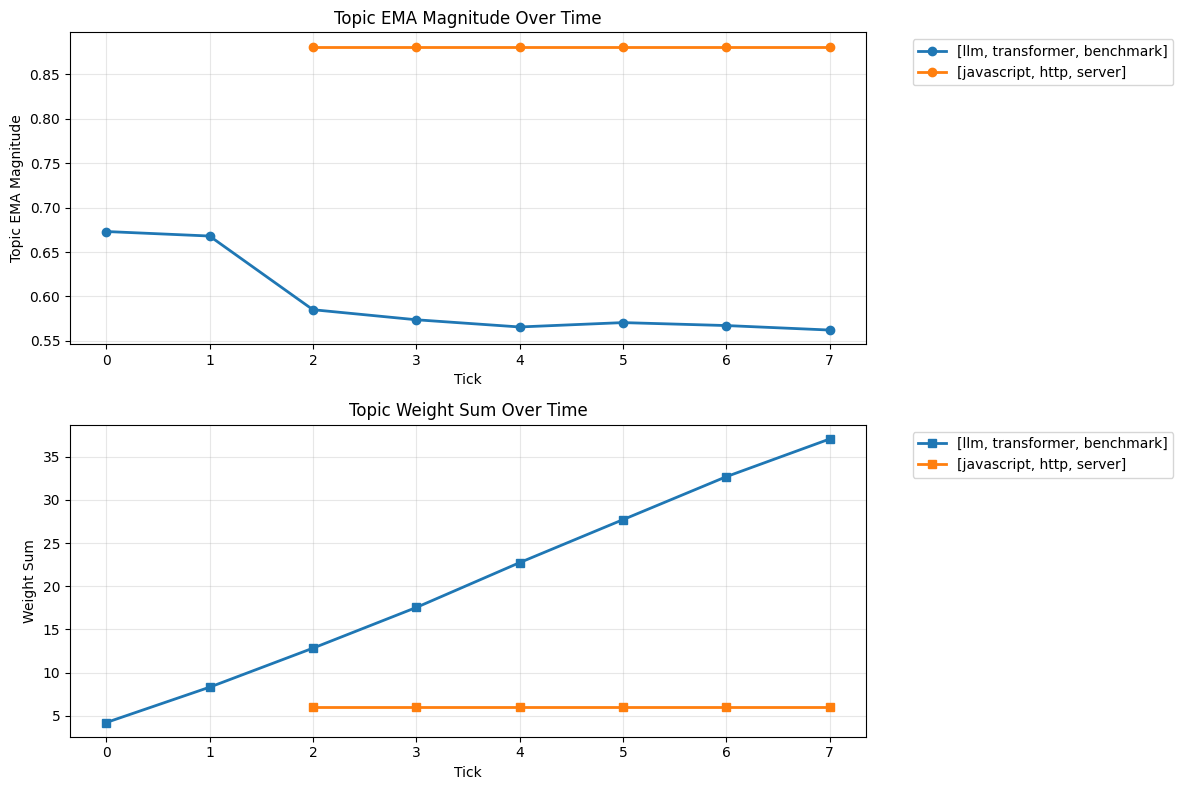


=== Topic Summary ===
Topic [llm, transformer, benchmark]:
  - First appearance: tick 0
  - Last appearance: tick 7
  - Max EMA magnitude: 0.673
  - Max weight sum: 37.055
  - Max clusters: 2

Topic [javascript, http, server]:
  - First appearance: tick 2
  - Last appearance: tick 7
  - Max EMA magnitude: 0.881
  - Max weight sum: 6.000
  - Max clusters: 0



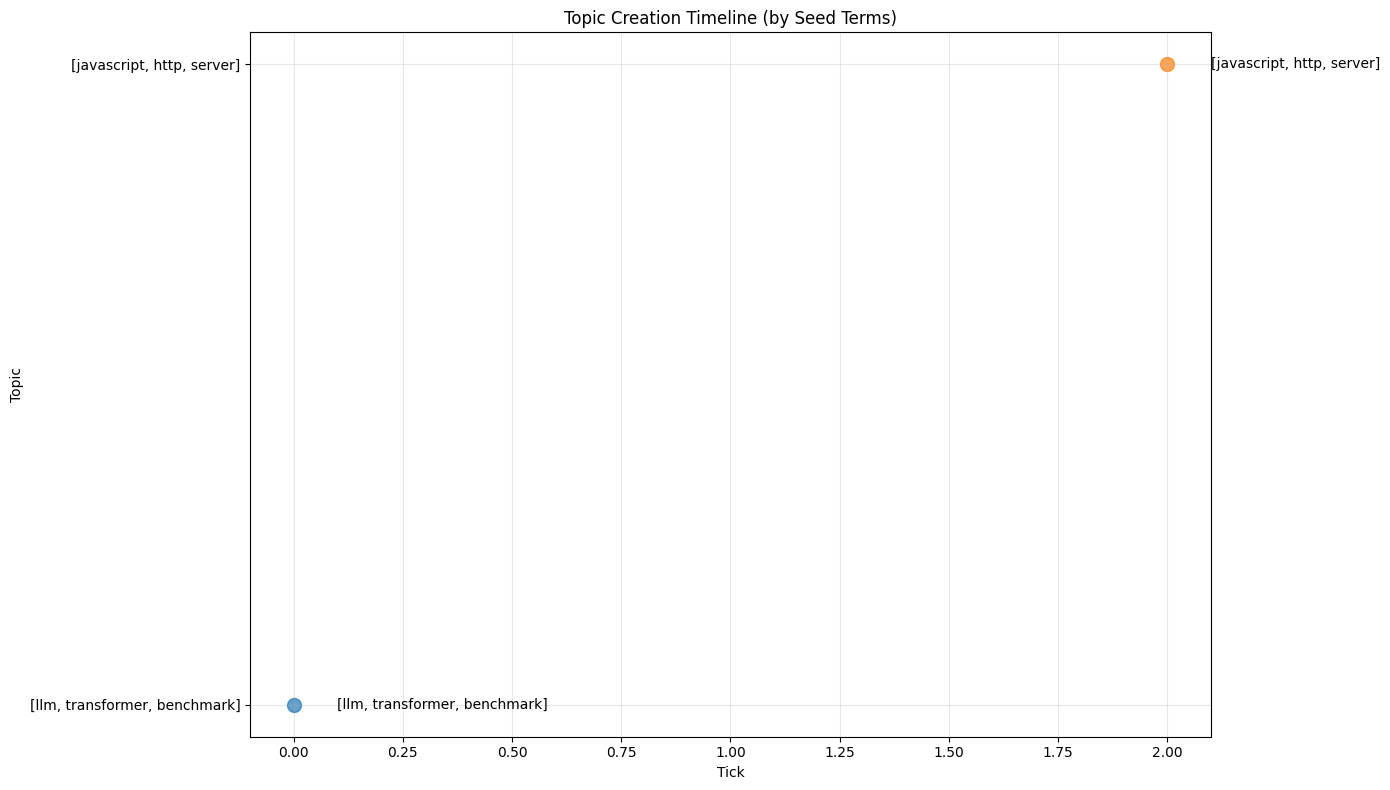

=== Topic Creation Timeline (by Seed Terms) ===
Topic [llm, transformer, benchmark]: First seen at tick 0
Topic [javascript, http, server]: First seen at tick 2


In [7]:
def plot_topic_creation_timeline_with_seeds(observations: List[Any]):
    """
    Create a timeline showing when topics first appear, using seed terms as labels.
    """
    topic_first_seen = {}
    topic_seeds = {}
    
    for obs in observations:
        topic_id = obs.topic.topic_id
        if topic_id not in topic_first_seen:
            topic_first_seen[topic_id] = obs.tick
            topic_seeds[topic_id] = obs.topic.seeds
    
    # Sort topics by first appearance
    sorted_topics = sorted(topic_first_seen.items(), key=lambda x: x[1])
    
    # Create timeline plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    y_pos = 0
    for topic_id, first_tick in sorted_topics:
        seeds = topic_seeds[topic_id]
        seeds_label = ', '.join(seeds[:3])  # Show first 3 seeds
        if len(seeds) > 3:
            seeds_label += '...'
        
        ax.scatter(first_tick, y_pos, s=100, alpha=0.7)
        ax.text(first_tick + 0.1, y_pos, f'[{seeds_label}]', va='center')
        y_pos += 1
    
    ax.set_xlabel('Tick')
    ax.set_ylabel('Topic')
    ax.set_title('Topic Creation Timeline (by Seed Terms)')
    ax.set_yticks(range(len(sorted_topics)))
    ax.set_yticklabels([f'[{", ".join(topic_seeds[tid][:3])}{"..." if len(topic_seeds[tid]) > 3 else ""}]' 
                       for tid, _ in sorted_topics])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("=== Topic Creation Timeline (by Seed Terms) ===")
    for topic_id, first_tick in sorted_topics:
        seeds = topic_seeds[topic_id]
        seeds_str = ', '.join(seeds)
        print(f"Topic [{seeds_str}]: First seen at tick {first_tick}")

# Run the updated visualization
plot_topic_ema_over_time(observer.observations)
plot_topic_creation_timeline_with_seeds(observer.observations)


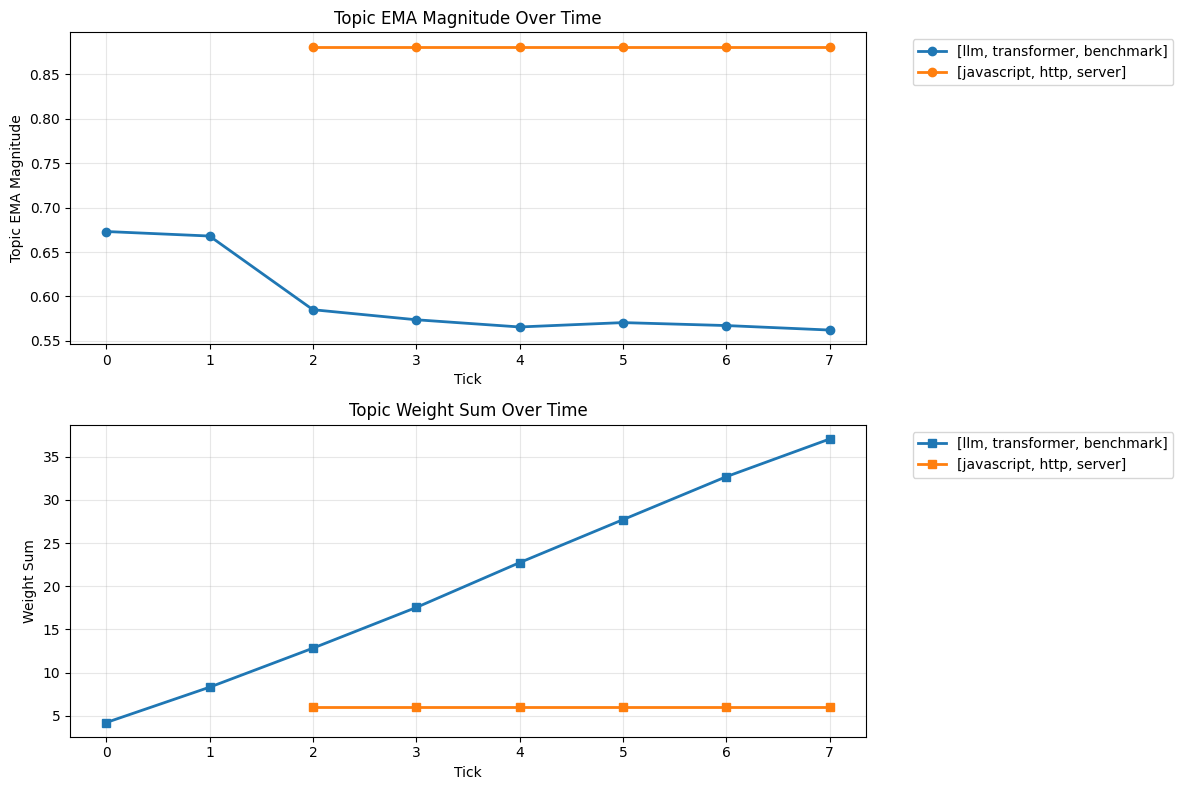


=== Topic Summary ===
Topic [llm, transformer, benchmark]:
  - First appearance: tick 0
  - Last appearance: tick 7
  - Max EMA magnitude: 0.673
  - Max weight sum: 37.055
  - Max clusters: 2

Topic [javascript, http, server]:
  - First appearance: tick 2
  - Last appearance: tick 7
  - Max EMA magnitude: 0.881
  - Max weight sum: 6.000
  - Max clusters: 0

No data found for the specified topic(s)


AttributeError: 'int' object has no attribute 'seeds'

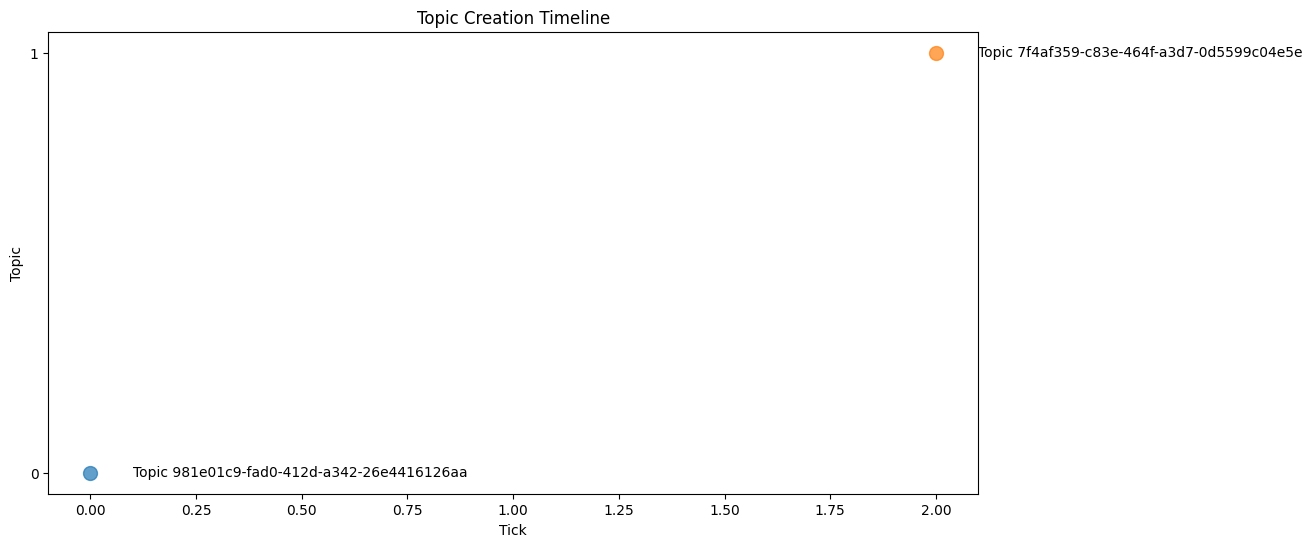

In [8]:
# Plot all topics over time
plot_topic_ema_over_time(observer.observations)

# Plot a specific topic
plot_topic_ema_over_time(observer.observations, topic_id="some-topic-id")

# See when topics were created
plot_topic_creation_timeline(observer.observations)